In [142]:
## %pip install obspy
## %pip install geopy
## %pip install scikit-learn
## %pip install statsmodels
## %pip install pandas

In [143]:
from obspy.clients.fdsn import Client
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd


def get_geolocation(city="Challis, ID"):
    """Fetch the latitude and longitude of a city."""
    geolocator = Nominatim(user_agent="TomPEQProject")
    try:
        loc = geolocator.geocode(city)
        if loc:
            return loc.latitude, loc.longitude
        else:
            print(f"City {city} not found.")
            return None
    except Exception as e:
        print(f"Error fetching geolocation for {city}: {e}")
        return None

def get_earthquake_data(client="USGS", city="Challis, ID", maxradius=1, starttime="1900-10-01", endtime="2024-10-11", minmagnitude=2.5):
    """Fetch earthquake events around a city."""
    lat, lon = get_geolocation(city)
    if lat is None or lon is None:
        return None

    try:
        catalog = client.get_events(starttime=starttime, 
                                endtime=endtime, 
                                minmagnitude=minmagnitude,
                                eventtype="earthquake",
                                latitude=lat,
                                longitude=lon,
                                maxradius=maxradius
                                )
        return catalog
    except Exception as e:
        print(f"Error fetching events: {e}")
        return None
    
def process_earthquake_data(catalog):
    """Process the fetched earthquake events and extract location information."""
    locs = []
    if catalog:
        for event in catalog:
            temp = event.origins[0]
            if temp.longitude is not None and temp.latitude is not None and temp.depth is not None:
                location = [temp.longitude, temp.latitude, temp.depth, temp.time, event.magnitudes[0].mag]  
                locs.append(location)
                #print(f"Event Time: {temp.time}, Magnitude: {event.magnitudes[0].mag}")
                #print(location)
        max_depth = max(locs, key=lambda x: x[2])[2]

        locs = np.array(locs)
        locs = locs[locs[:, 3].argsort()]
        
        return locs, max_depth
    else:
        return None
    
def normalize_depth(locs):
    """Normalize the depth values."""
    scaler = MinMaxScaler()
    locs[:, 2] = -scaler.fit_transform(locs[:, 2].reshape(-1, 1)).flatten()
    return locs

city = "Challis, ID"
client = Client("USGS")
catalog = get_earthquake_data(client=client, city=city, maxradius=1)
if catalog:
    locs, max_depth = process_earthquake_data(catalog)
    locs = normalize_depth(locs)

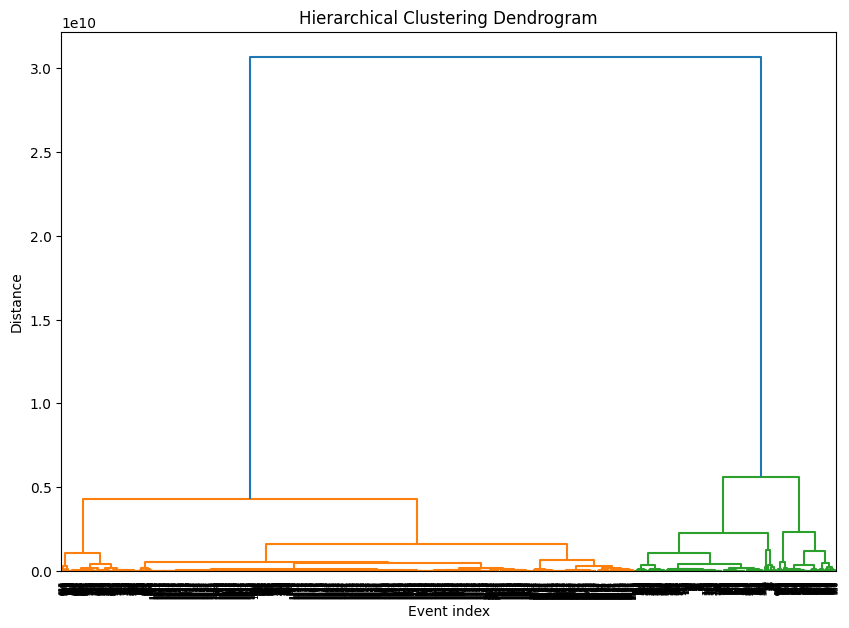

In [144]:
def perform_clustering(locs):
    """Perform hierarchical clustering on earthquake locations."""
    linked = linkage(locs, method='ward')
    return linked

def perform_labeling(linked, k):
    labels = fcluster(linked, k, criterion='maxclust')
    return labels

def plot_dendrogram(linked):
    """Plot the hierarchical clustering dendrogram."""
    plt.figure(figsize=(10, 7))
    dendro = dendrogram(linked)
    color_dict = {color for color in dendro['color_list']}
    num_colors = len(color_dict)
    
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('Event index')
    plt.ylabel('Distance')
    plt.show()
    
    return num_colors - 1


linked = perform_clustering(locs)
k = plot_dendrogram(linked)
labels = perform_labeling(linked, k)

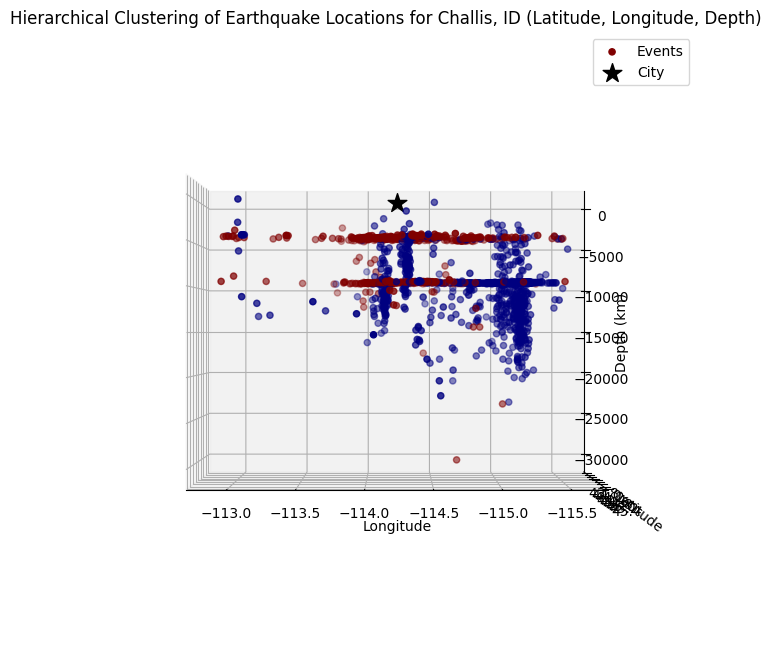

In [145]:
def plot_3d_clusters(locs, labels, city, max_depth, elev, azim):
    """Plot the 3D scatter plot of earthquake locations and clusters."""
    fig = plt.figure(figsize=(10,8))
    lat, lon = get_geolocation(city=city)

    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(locs[:, 0], locs[:, 1], locs[:, 2]*max_depth, c=labels, cmap='jet', marker='o', label='Events')
    ax.scatter(lon, lat, 0, c='black', marker='*', s=200, label='City')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth (km)')

    ax.set_title(f'Hierarchical Clustering of Earthquake Locations for {city} (Latitude, Longitude, Depth) ')
    ax.legend()

    ax.view_init(elev=elev, azim=azim)

    plt.show()
    

plot_3d_clusters(locs, labels, city, max_depth, elev=0, azim=90)

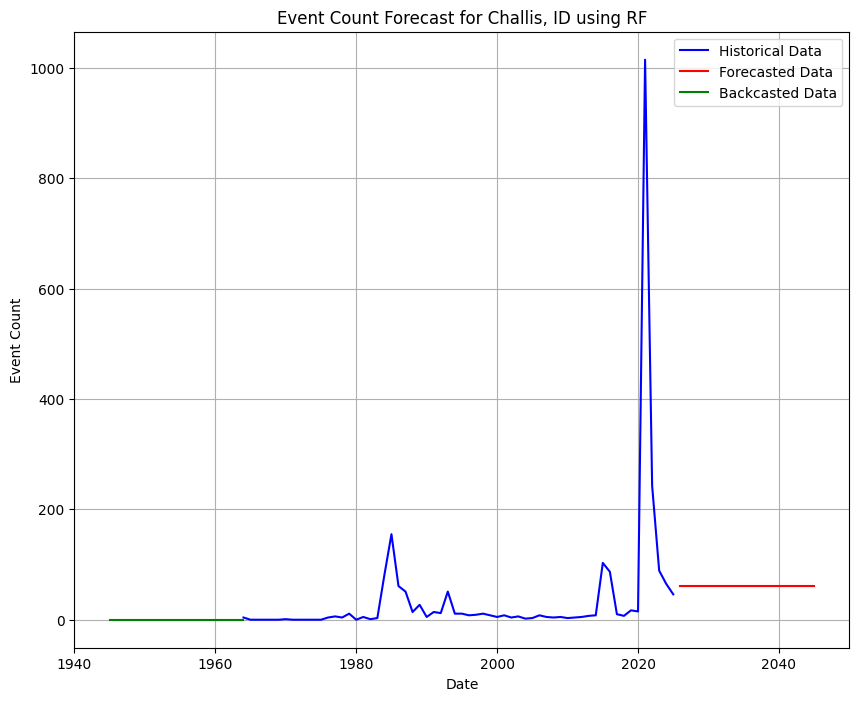


Predicted Number of Events for Challis, ID in the prior 20 YEs:
1944-12-31    0.02
1945-12-31    0.02
1946-12-31    0.02
1947-12-31    0.02
1948-12-31    0.02
1949-12-31    0.02
1950-12-31    0.02
1951-12-31    0.02
1952-12-31    0.02
1953-12-31    0.02
1954-12-31    0.02
1955-12-31    0.02
1956-12-31    0.02
1957-12-31    0.02
1958-12-31    0.02
1959-12-31    0.02
1960-12-31    0.02
1961-12-31    0.02
1962-12-31    0.02
1963-12-31    0.02
Predicted Number of Events for Challis, ID in the next 20 YEs:
2025-12-31    60.55
2026-12-31    60.55
2027-12-31    60.55
2028-12-31    60.55
2029-12-31    60.55
2030-12-31    60.55
2031-12-31    60.55
2032-12-31    60.55
2033-12-31    60.55
2034-12-31    60.55
2035-12-31    60.55
2036-12-31    60.55
2037-12-31    60.55
2038-12-31    60.55
2039-12-31    60.55
2040-12-31    60.55
2041-12-31    60.55
2042-12-31    60.55
2043-12-31    60.55
2044-12-31    60.55


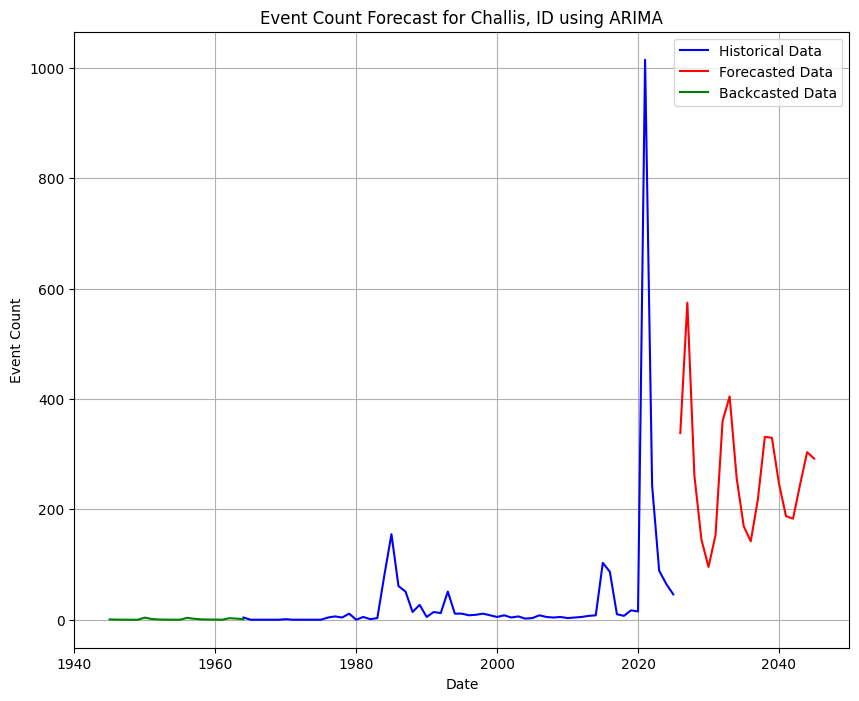


Predicted Number of Events for Challis, ID in the prior 20 YEs:
1944-12-31    0.64
1945-12-31    0.16
1946-12-31    0.03
1947-12-31    0.00
1948-12-31    0.00
1949-12-31    3.79
1950-12-31    1.21
1951-12-31    0.40
1952-12-31    0.13
1953-12-31    0.03
1954-12-31    0.00
1955-12-31    3.38
1956-12-31    1.67
1957-12-31    0.69
1958-12-31    0.28
1959-12-31    0.24
1960-12-31    0.00
1961-12-31    2.82
1962-12-31    1.99
1963-12-31    1.00
Predicted Number of Events Challis, ID for the next 20 YEs:
2025-12-31    338.305990
2026-12-31    574.658225
2027-12-31    261.631138
2028-12-31    145.154324
2029-12-31     95.631008
2030-12-31    153.547005
2031-12-31    360.064709
2032-12-31    404.764833
2033-12-31    256.652995
2034-12-31    169.483476
2035-12-31    142.087466
2036-12-31    217.524576
2037-12-31    331.388850
2038-12-31    329.868742
2039-12-31    247.232358
2040-12-31    187.722748
2041-12-31    183.197080
2042-12-31    244.930563
2043-12-31    303.682012
2044-12-31    292.01

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings

def predict_Seismic_RF(city, locs, duration=30, freq='YE'):
    """Predict the number of earthquake events in a future/Past time span using Random Forest."""
    
    event_times = [time.datetime for time in locs[:, 3]] # Convert to datetime
    
    event_counts = pd.Series(1, index=pd.to_datetime(event_times)).resample(freq).count() # Count number of events per freq
    
    event_counts_df = pd.DataFrame(event_counts)
    event_counts_df['year'] = event_counts_df.index.year
    event_counts_df['month'] = event_counts_df.index.month
    event_counts_df['day'] = event_counts_df.index.day
    
    X = event_counts_df[['year', 'month', 'day']]
    y = event_counts_df[0]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    future_dates = pd.date_range(event_counts.index[-1], periods=duration+1, freq=freq)[1:]
    future_features = pd.DataFrame({
        'year': future_dates.year,
        'month': future_dates.month,
        'day': future_dates.day
    })
    
    forecast = rf_model.predict(future_features)
    
    past_dates = pd.date_range(event_counts.index[0] - pd.DateOffset(years=duration), periods=duration+1, freq=freq)[1:]
    backcast_features = pd.DataFrame({
        'year': past_dates.year,
        'month': past_dates.month,
        'day': past_dates.day
    })
    backcast = rf_model.predict(backcast_features)
    
    plt.figure(figsize=(10, 8))
    plt.plot(event_counts.index, event_counts, label='Historical Data', color='blue')  # Historical data plot
    plt.plot(future_dates, forecast, label='Forecasted Data', color='red')  # Forecast data plot
    plt.plot(past_dates, backcast, label='Backcasted Data', color='green')
    plt.title(f'Event Count Forecast for {city} using RF')
    plt.xlabel('Date')
    plt.ylabel('Event Count')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # For Readability
    print(f"\nPredicted Number of Events for {city} in the prior {duration} {freq}s:")
    for date, count in zip(past_dates, backcast):
        print(f"{date.strftime('%Y-%m-%d')}    {count:.2f}")
    print(f"Predicted Number of Events for {city} in the next {duration} {freq}s:")
    for date, count in zip(future_dates, forecast):
        print(f"{date.strftime('%Y-%m-%d')}    {count:.2f}")

def predict_Seismic_ARIMA(city, locs, duration=30, freq='YE'):
    """Predict the number of earthquake events in a future time span using ARIMA."""
    
    event_times = [time.datetime for time in locs[:, 3]] # Convert to datetime
    
    event_counts = pd.Series(1, index=pd.to_datetime(event_times)).resample(freq).count() # Count number of events per freq
    
    event_counts_reversed = event_counts[::-1] # For Backcasting
    
    warnings.filterwarnings("ignore") # Warning caused by performing back prediction and non-stationary
    model = ARIMA(event_counts, order=(5, 1, 0)) # Create ARIMA model
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=duration) # Create forecast
    future_dates = pd.date_range(event_counts.index[-1], periods=duration+1, freq=freq)[1:] # Starting at end of historical data
    
    model = ARIMA(event_counts_reversed, order=(5, 1, 0)) # Create ARIMA model
    model_fit = model.fit()
    backcast = model_fit.forecast(steps=duration) # Create forecast 
    past_dates = pd.date_range(event_counts.index[0] - pd.DateOffset(years=duration), periods=duration+1, freq=freq)[1:]
    warnings.filterwarnings("default")
    
    forecast[forecast < 0] = 0
    backcast[backcast < 0] = 0
    
    plt.figure(figsize=(10, 8))
    plt.plot(event_counts.index, event_counts, label='Historical Data', color='blue')  # Historical data plot
    plt.plot(future_dates, forecast, label='Forecasted Data', color='red')  # Forecast data plot
    plt.plot(past_dates, backcast, label='Backcasted Data', color='green')
    plt.title(f'Event Count Forecast for {city} using ARIMA')
    plt.xlabel('Date')
    plt.ylabel('Event Count')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # For Readability
    print(f"\nPredicted Number of Events for {city} in the prior {duration} {freq}s:")
    for date, count in zip(past_dates, backcast):
        print(f"{date.strftime('%Y-%m-%d')}    {count:.2f}")
    print(f"Predicted Number of Events {city} for the next {duration} {freq}s:\n{forecast}")

predict_Seismic_RF(city, locs, duration=20, freq='YE')
predict_Seismic_ARIMA(city, locs, duration=20, freq='YE')

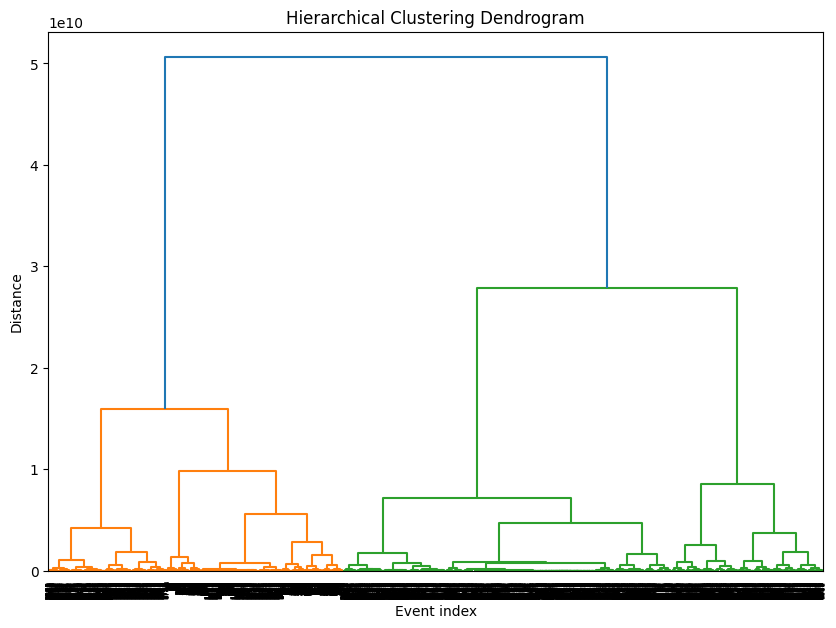

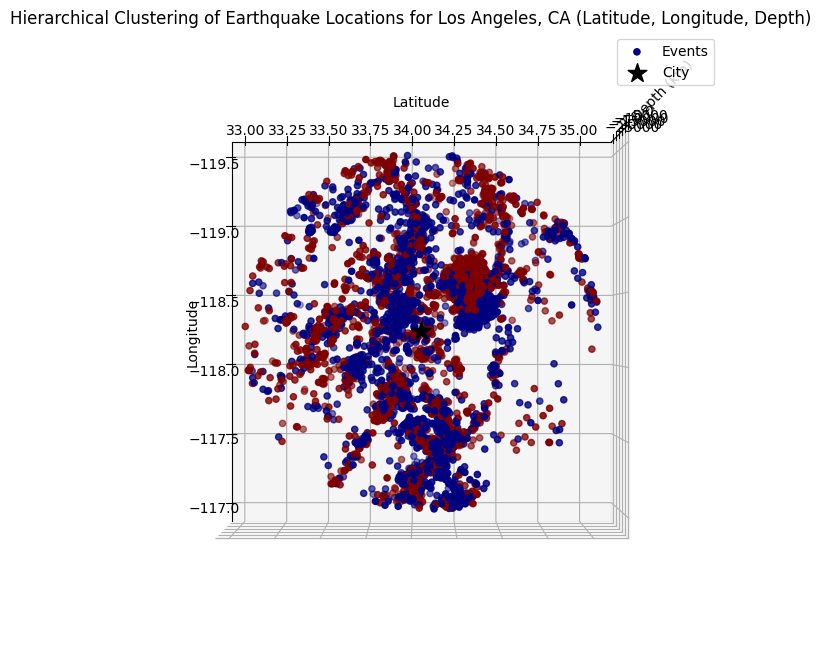

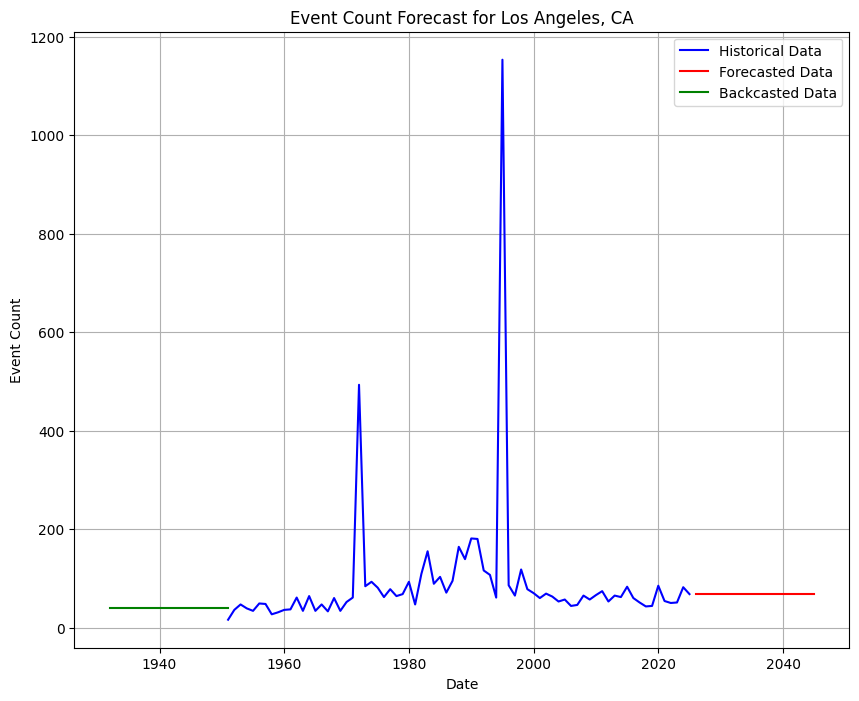


Predicted Number of Events for Los Angeles, CA in the prior 20 YEs:
1931-12-31    38.89
1932-12-31    38.89
1933-12-31    38.89
1934-12-31    38.89
1935-12-31    38.89
1936-12-31    38.89
1937-12-31    38.89
1938-12-31    38.89
1939-12-31    38.89
1940-12-31    38.89
1941-12-31    38.89
1942-12-31    38.89
1943-12-31    38.89
1944-12-31    38.89
1945-12-31    38.89
1946-12-31    38.89
1947-12-31    38.89
1948-12-31    38.89
1949-12-31    38.89
1950-12-31    38.89
Predicted Number of Events for Los Angeles, CA in the next 20 YEs:
2025-12-31    68.27
2026-12-31    68.27
2027-12-31    68.27
2028-12-31    68.27
2029-12-31    68.27
2030-12-31    68.27
2031-12-31    68.27
2032-12-31    68.27
2033-12-31    68.27
2034-12-31    68.27
2035-12-31    68.27
2036-12-31    68.27
2037-12-31    68.27
2038-12-31    68.27
2039-12-31    68.27
2040-12-31    68.27
2041-12-31    68.27
2042-12-31    68.27
2043-12-31    68.27
2044-12-31    68.27


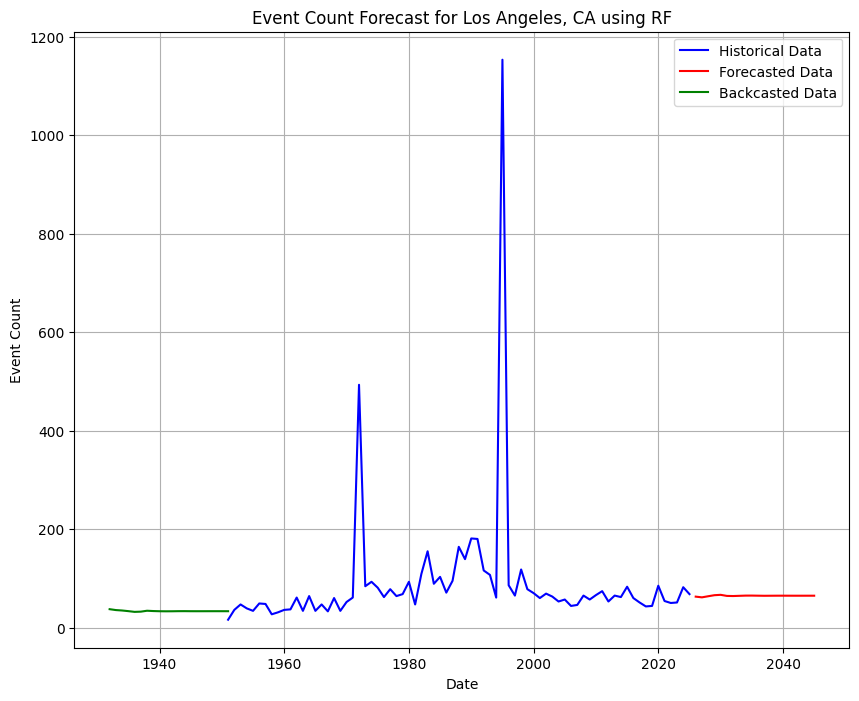


Predicted Number of Events for Los Angeles, CA in the prior 20 YEs:
1931-12-31    37.38
1932-12-31    35.59
1933-12-31    34.72
1934-12-31    33.42
1935-12-31    31.95
1936-12-31    32.39
1937-12-31    34.23
1938-12-31    33.61
1939-12-31    33.24
1940-12-31    33.10
1941-12-31    33.17
1942-12-31    33.36
1943-12-31    33.42
1944-12-31    33.29
1945-12-31    33.26
1946-12-31    33.28
1947-12-31    33.30
1948-12-31    33.31
1949-12-31    33.30
1950-12-31    33.29
Predicted Number of Events Los Angeles, CA for the next 20 YEs:
2025-12-31    62.865708
2026-12-31    61.430191
2027-12-31    63.657525
2028-12-31    65.794232
2029-12-31    66.541242
2030-12-31    64.342338
2031-12-31    64.094766
2032-12-31    64.522386
2033-12-31    64.952380
2034-12-31    65.000635
2035-12-31    64.795679
2036-12-31    64.613704
2037-12-31    64.700892
2038-12-31    64.789672
2039-12-31    64.803324
2040-12-31    64.767310
2041-12-31    64.739005
2042-12-31    64.742730
2043-12-31    64.762418
2044-12-31 

In [149]:
def perform_Seismitc_Analysis(city="Challis, ID", maxradius=1, data_starttime="1900-10-01", data_endtime="2024-10-11", elev=0, azim=90):   
    client = Client("USGS")
    catalog = get_earthquake_data(client=client, city=city, maxradius=maxradius, 
                                  starttime=data_starttime, endtime=data_endtime)
    if catalog:
        locs, max_depth = process_earthquake_data(catalog)
        locs = normalize_depth(locs)
    

    linked = perform_clustering(locs)
    k = plot_dendrogram(linked)
    labels = perform_labeling(linked, k)

    plot_3d_clusters(locs, labels, city, max_depth, elev=elev, azim=azim)
    
    predict_Seismic_RF(city, locs, duration=20, freq='YE')
    predict_Seismic_ARIMA(city, locs, duration=20, freq='YE')

perform_Seismitc_Analysis(city="Los Angeles, CA", maxradius=1, elev=90, azim=0, data_starttime="1950-10-01")

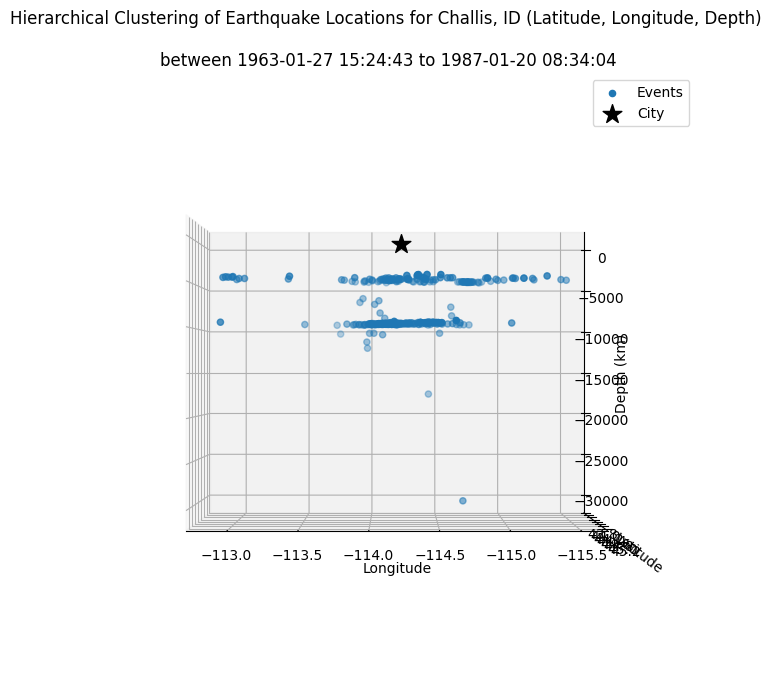

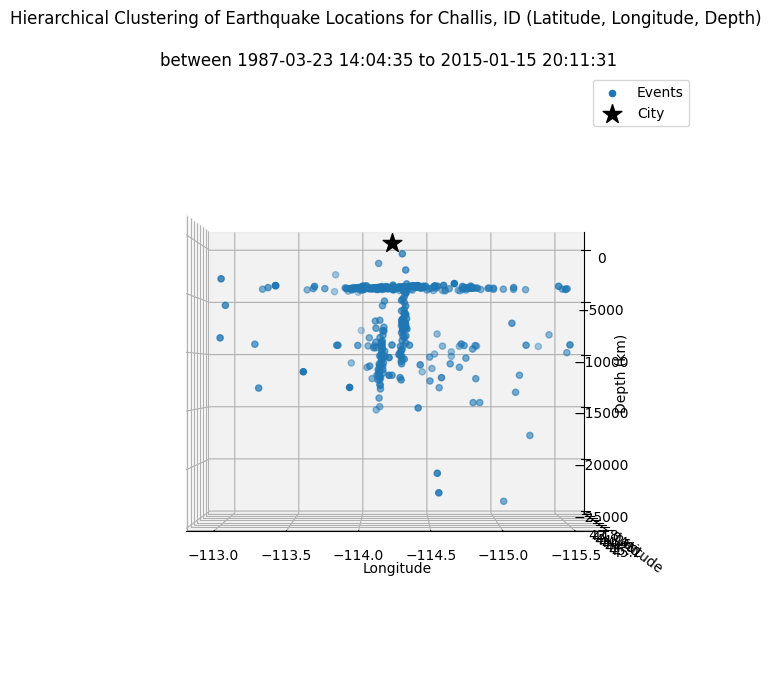

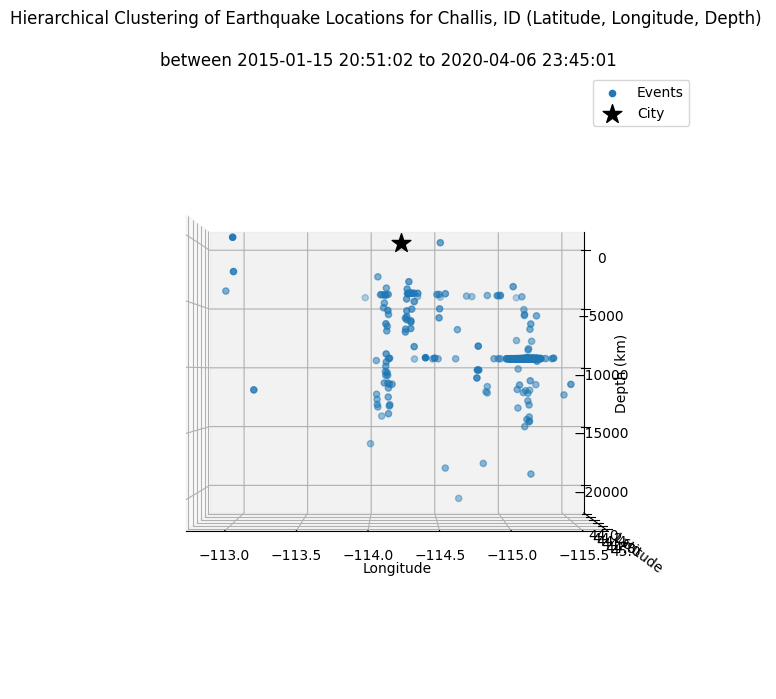

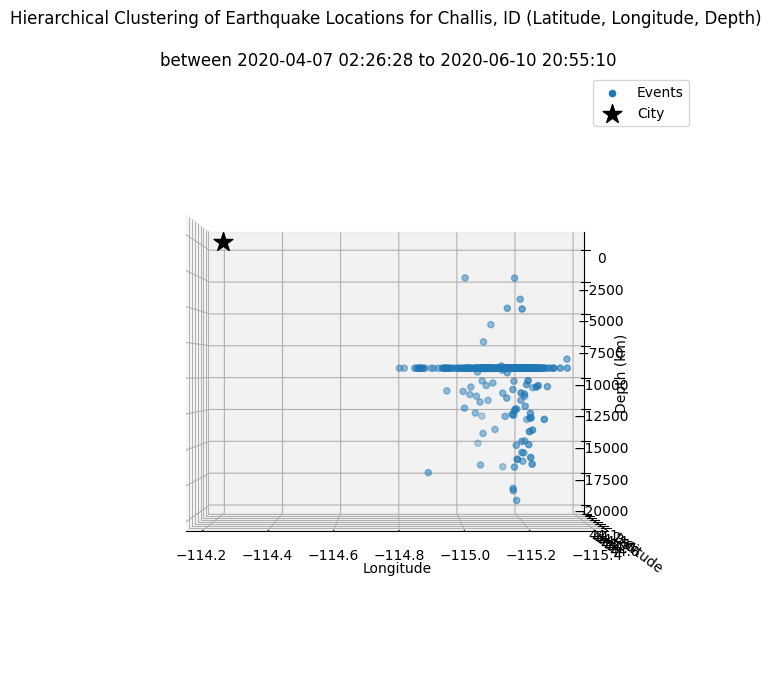

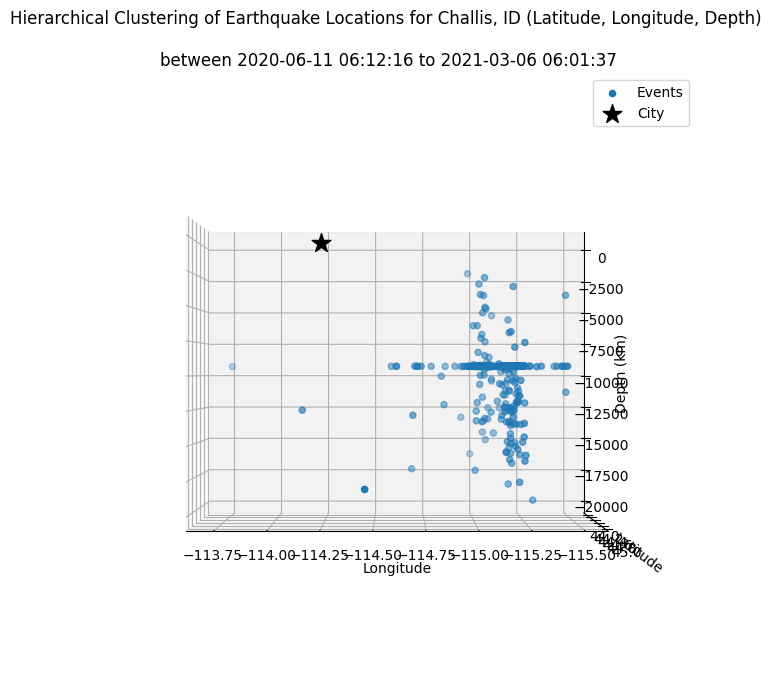

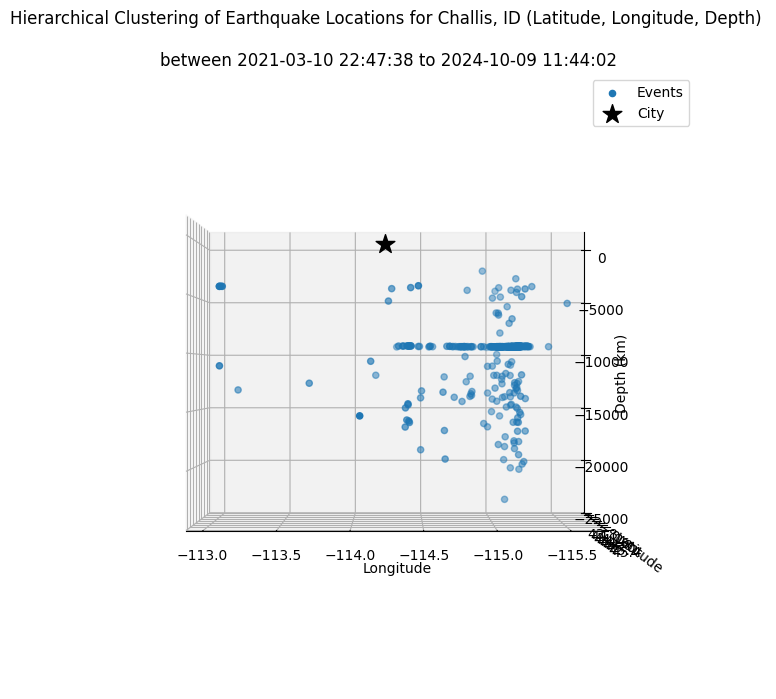

In [148]:
def split_by_date(locs, num_splits=6):
    """Splits the data into equals sections"""
    splits = np.array_split(locs, num_splits)
    return splits

def show_progression(city="Challis, ID", maxradius=1, elev=0, azim=90):
    client = Client("USGS")
    catalog = get_earthquake_data(client=client, city=city, maxradius=maxradius)
    if catalog:
        locs, max_depth = process_earthquake_data(catalog)
        locs = normalize_depth(locs)
        
        split_locs = split_by_date(locs,6)
        
        lat, lon = get_geolocation(city=city)

        
        # Create a 3D plot for each split
        for i, split in enumerate(split_locs):
            
            
            start_time = split[0, 3]
            end_time = split[-1, 3]
            
            # Get Time range of each split
            start_time_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
            end_time_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
            time_range_str = f"{start_time_str} to {end_time_str}"
            
            fig = plt.figure(figsize=(10, 8))
            ax = fig.add_subplot(111, projection='3d')
            scatter = ax.scatter(split[:, 0], split[:, 1], split[:, 2] * max_depth, 
                                 label=f'Events', marker='o')
        
            ax.scatter(lon, lat, 0, c='black', marker='*', s=200, label='City')

            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')
            ax.set_zlabel('Depth (km)')

            ax.set_title(f"""Hierarchical Clustering of Earthquake Locations for {city} (Latitude, Longitude, Depth) 
                         \nbetween {time_range_str}""")
            ax.legend()

            ax.view_init(elev=elev, azim=azim)

            plt.show()
    else:
        return None

show_progression(city="Challis, ID", maxradius=1, elev=0, azim=90)